# An case example: Bounce time from a website 
**From:** https://www.kaggle.com/ojwatson/mixed-models/

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Imports and install

In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set()

In [2]:
!pip install statsmodels

## Understanding the Problem Statement and Dataset

In this notebook we will analyse a dataset that looks at the bounce times of users of a website with cooking recipes. The bounce time is a measure of how quickly someone leaves a website, e.g. the number of seconds after which a user first accesses a webpage from the website and then leaves. 

Most websites want individuals to stay on their websites for a long time as they are more likely to read another article, buy one of their products, click on some of the sponsored links etc. As such, it can be useful to understand why some users leave the website quicker than others.

To investigate the bounce time of the website, we chose three locations in 8 counties in England, and got members of the public of all ages to undertake a survey/test questionaire. In the test we asked them to use our search engine to query for something they want to eat this evening. The search engine listed our website first, as well as other websites that would be returned. The users that clicked on our website were then timed and their bounce time recorded. We also recorded their age, and made a note of the county and location.

We have been asked by the website to work out if younger individuals are more likely to leave the website quicker.

In [3]:
# read in our data
data = pd.read_csv('Bounce.csv')
data.head(15)

bounce_time  age county location
0    165.548520   16  devon        a
1    167.559314   34  devon        a
2    165.882952    6  devon        a
3    167.685525   19  devon        a
4    169.959681   34  devon        a
5    168.688747   47  devon        a
6    169.619382    7  devon        a
7    164.416273    8  devon        a
8    167.510430    8  devon        a
9    179.606068    7  devon        a
10   174.465485   40  devon        a
11   164.781248   38  devon        a
12   172.559467   23  devon        a
13   179.000774    7  devon        a
14   175.970409   18  devon        a

As we can see, there is the bounce time in seconds, the age of the person, the county they live in, and there is a location code for the place the person was recruited inside the county. Let's take the approach of kind of exploring the data with descriptive statistics and plots to get a sense of what is going on.

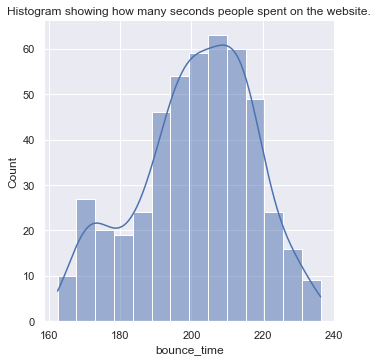

In [4]:
# plot the distribution of the bounce times
sns.displot(data.bounce_time,kde=True)
plt.title("Histogram showing how many seconds people spent on the website.")
plt.show()

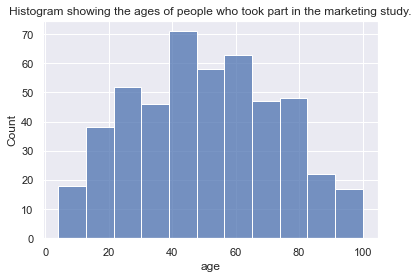

In [5]:
# plot the distribution of the ages
sns.histplot(data.age,kde=False)
plt.title("Histogram showing the ages of people who took part in the marketing study.")
plt.show()

from sklearn import preprocessing
data["age_scaled"] = preprocessing.scale(data.age.values)

### Remark:
It is often a good idea to scale our independent (explanatory) variables so that they are standardised. This is useful as it means that any estimated coefficient from our regression model later on are all on the same scale. This scaling won't impact the statistical findings in our example but you may find in more complex models than the one in this tutorial this can be very helpful in speeding up your models fitting. It is also makes comparison between a continous variable like age, and a binary variable (0, 1) more fair. 

## Simple Linear Regression

One thing we might want to do to see if the bounce time is dependent on the age is to plot this data, and then fit a linear regression to the data:

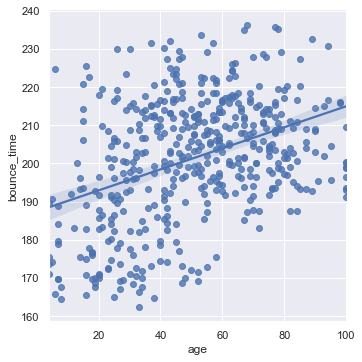

In [6]:
sns.lmplot(x = "age", y = "bounce_time", data = data)

It would seem, from this simple analysis that older people do spend longer time on the website. To go into this further let's look at what the coefficients estimated are within our linear model.

$$ \texttt{time} = b_0 + b_1\texttt{age} \,, $$
where $b_1$ is the rate of change of the bounce time with respect to $\texttt{age}$ and $b_0$ the intercept when $\texttt{age}$ is 0.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


Model slope:     6.27960200797082
Model intercept: 201.31646151854164


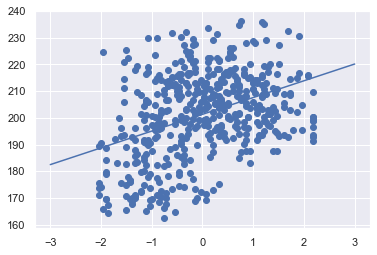

In [7]:
from sklearn.linear_model import LinearRegression

model = LinearRegression(fit_intercept=True)
x = data.age_scaled
y = data.bounce_time
model.fit(x[:, np.newaxis], y)

xfit = np.linspace(-3, 3, 1000)
yfit = model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit);

print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

In [8]:
y_predict = model.predict(x.values.reshape(-1,1))
RMSE = np.sqrt(((y-y_predict)**2).values.mean())

results = pd.DataFrame()
results["Method"] = ["Linear Regression"]
results["RMSE"] = RMSE
results

Method       RMSE
0  Linear Regression  14.928334

So from this we would say quite confidently that as age increases so does the bounce time.

However, to run a linear regression a number of assumptions about the data need to be met. One of these is that the residuals are homoscedastic, which means that the residuals are normally distributed in relation to the predicted value, i.e. are our predictions equally bad (or good) across our predicted values. We can look at this by plotting the residuals:

In [9]:
!pip install yellowbrick

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


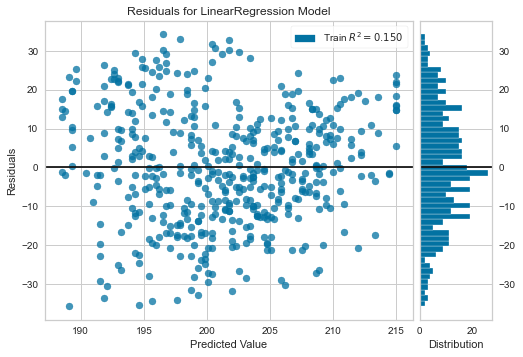

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [10]:
import yellowbrick
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(model = model)

visualizer.fit(x[:, np.newaxis], y)  # Fit the training data to the model
visualizer.poof()                    # Draw/show/poof the data


There are more positive residuals than negative residuals at the highest and lowest predicted value ranges, e.g. predicted value < 195, and >210 there are more positive residuals than negative. You can have a look at this also using $\texttt{seaborn}$'s residplot:

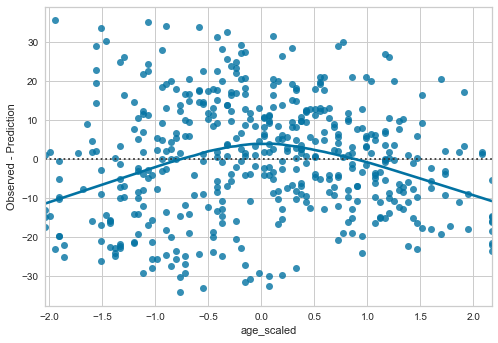

In [11]:
ax = sns.residplot(x = "age_scaled", y= "bounce_time", data = data, lowess = True)
ax.set(ylabel='Observed - Prediction')
plt.show()

Simple linear regression looks not ideal... Let's check some of the other assumptions. 

For a good list of the assumptions (with code in R), have a look here http://r-statistics.co/Assumptions-of-Linear-Regression.html.

One of the other key assumption is that the observations of our data are independent of the other data. When we collected our data we were doing it in 8 different counties and in 3 locations within each county. So we could check this by comparing the bounce times for each county. 

/opt/anaconda3/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


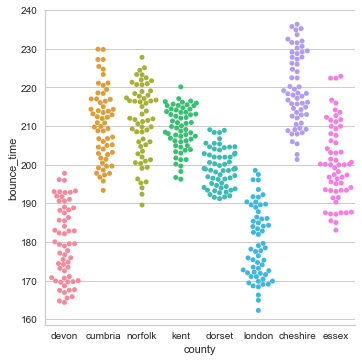

In [12]:
sns.catplot(x="county", y="bounce_time", data=data, kind = "swarm")

Clearly there is substantial grouping. So we can definitely say that our data is not independent, and thus it is inappropriate to use a linear model for this data.

### Remark: Is this  linear regression significant?
It looked as if the coefficient for the gradient was significant, _i.e._ there was in fact a positive relationship between age and bounce time. However, to be sure we could use a statistical test, such as the **t.test** to test this. This can be often useful and can be used to produce **p.values** which gives us a measure of how confident we are about something. In this we will test whether the intercept and mean are significantly different from 0.

In [13]:
from scipy import stats

params = np.append(model.intercept_,model.coef_)

# Simulate some new data for the model and then compare what the error is for these 
newx = pd.DataFrame({"Constant":np.ones(len(x))}).join(pd.DataFrame(x))
MSE = (sum((y-y_predict)**2))/(len(newx)-len(newx.columns))

# and whats the variance, standard deviation, t values and p-values
var_b = MSE*(np.linalg.inv(np.dot(newx.T,newx)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b
p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newx)-1))) for i in ts_b]

# and let's group it together
names = ["intercept", "age"]
summary = pd.DataFrame()
summary["names"],summary["Coefficients"],summary["Standard Errors"] = [names,params,sd_b]
summary["t values"],summary["Probabilites"] = [ts_b,p_values]
print(summary)

       names  Coefficients  Standard Errors    t values  Probabilites
0  intercept    201.316462         0.682806  294.836946           0.0
1        age      6.279602         0.682806    9.196758           0.0


## Separate Linear Regression

Same as before, we are going to fit a linear regression to the data, but first separating it by county. Mathematically, this now looks like:

$$
\texttt{time}_c = b_{c0} + b_{c1}\texttt{age} \,.
$$

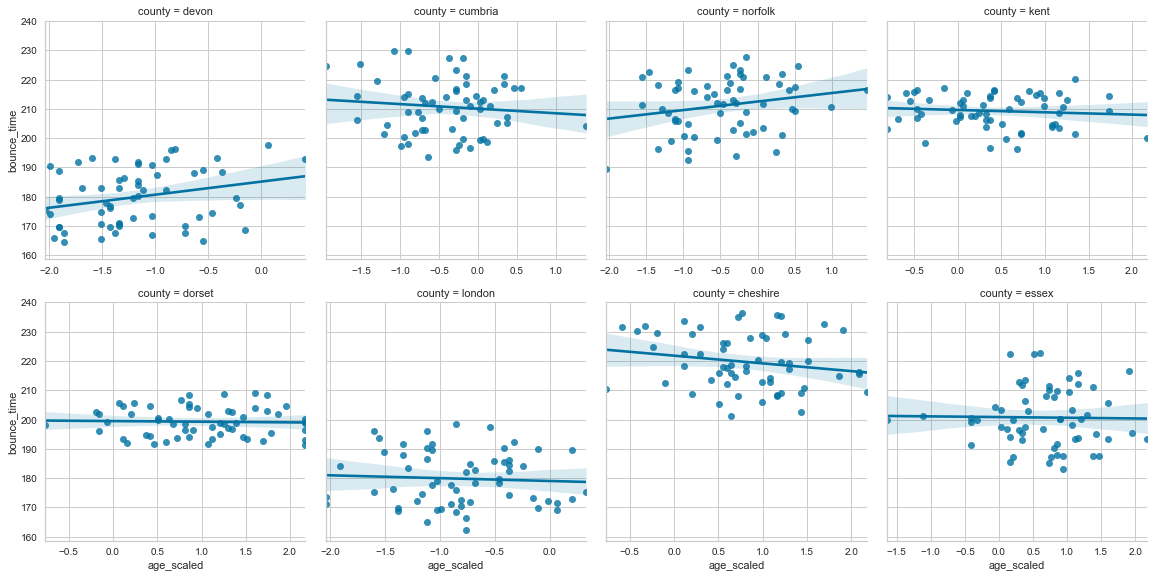

In [14]:
grid = sns.lmplot(x = "age_scaled", y = "bounce_time", col = "county", sharex=False, col_wrap = 4, data = data, height=4)

So now we have 8 different analyses. This is fine, but we have started to reduce our sample size a lot already as a result, and we are now perhaps going too far in the other direction from before. Before we were saying that all counties were identical, whereas here we are saying that the impact of age on bounce_time share no similarities between counties, which is probably again not true.

In addition, what about our location variable, maybe our data is also not independent when looking at location

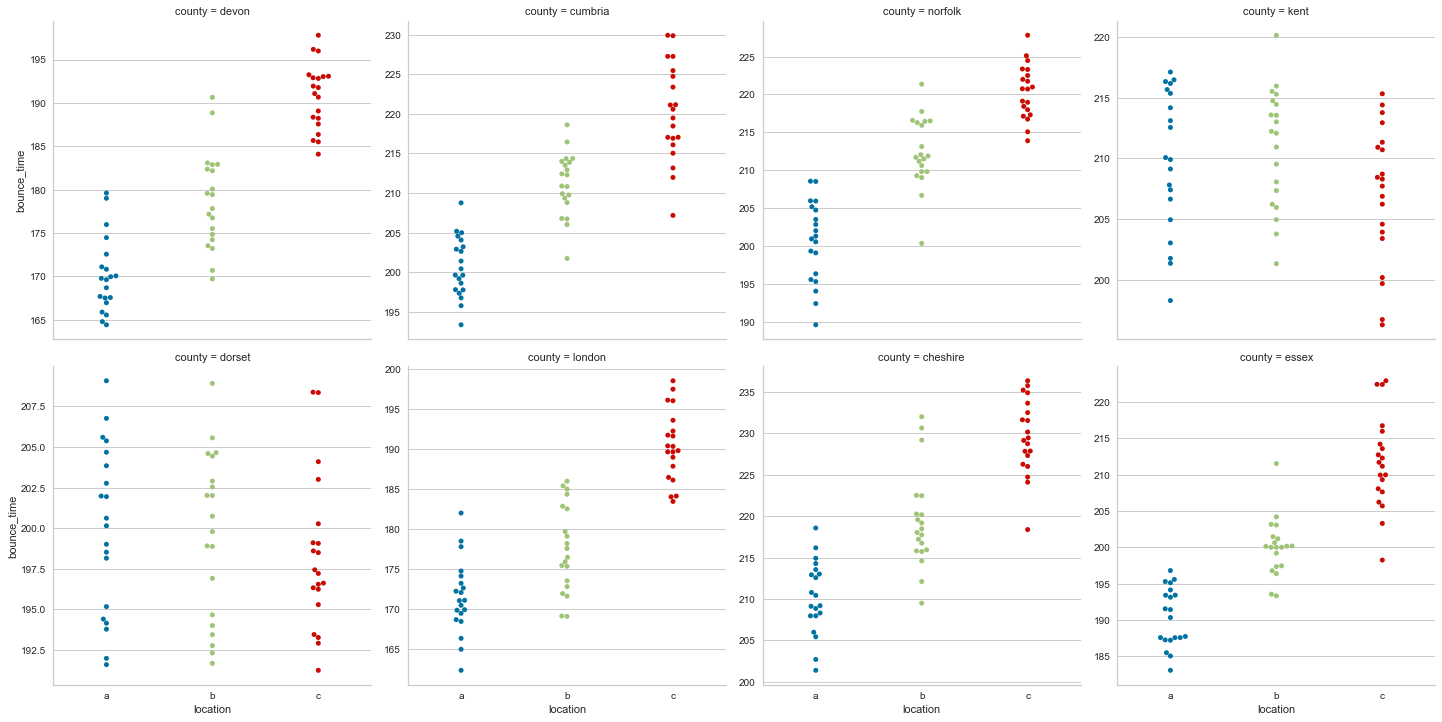

In [15]:
sns.catplot(x="location", y="bounce_time", col="county", col_wrap=4, sharey=False, data=data, kind = "swarm")

So we could carry on and then do an individual regression for each location within each county... hopefully you can see why we can't always just do an individual regression for each new group. If we did we would have to to estimate a slope and intercept parameter for each regression. That’s two parameters, three locations and eight counties, which means 48 parameter estimates (2 x 3 x 8 = 48).

Also we would now be taking our nice dataset of 480 observations, that presumably took a long time to collect, and effectively reducing it to lots of sample sizes of 20. This really decreases our statistical power, and thus also increases our chances of errors by carrying out multiple comparisons.

## Modelling county as a fixed effect

One way to incorporate the impact of county is to bring the county in to our equation for the linear model by treating it as a fixed effect. This would look like: 

$$
\texttt{time}_{c_{i}} = b_{0} + b_{1}\texttt{age} + c_i
$$

_i.e._ each county has it's own additional term that wil change the intercept. To model this we will need to alter our dataframe to encode our counties as numeric variables. So we will use one-hot encoding, where we will make a new column for each county:

In [16]:
# make a new data frame with one hot encoded columns for the counties
counties = data.county.unique()
data_new = pd.concat([data,pd.get_dummies(data.county)],axis=1)
data_new.head()

bounce_time  age county location  age_scaled  cheshire  cumbria  devon  \
0   165.548520   16  devon        a   -1.512654         0        0      1   
1   167.559314   34  devon        a   -0.722871         0        0      1   
2   165.882952    6  devon        a   -1.951423         0        0      1   
3   167.685525   19  devon        a   -1.381024         0        0      1   
4   169.959681   34  devon        a   -0.722871         0        0      1   

   dorset  essex  kent  london  norfolk  
0       0      0     0       0        0  
1       0      0     0       0        0  
2       0      0     0       0        0  
3       0      0     0       0        0  
4       0      0     0       0        0

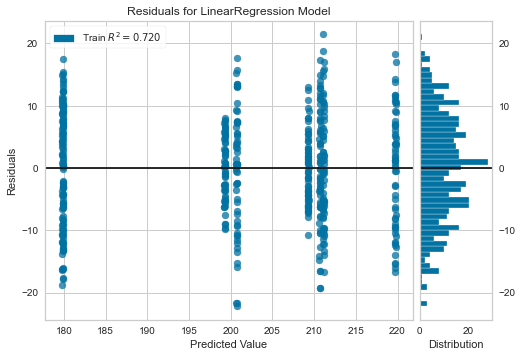

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [17]:
# construct our linear regression model
model = LinearRegression(fit_intercept=True)
x = data_new.loc[:,np.concatenate((["age_scaled"],counties))]
y = data.bounce_time
model.fit(x, y)

visualizer = ResidualsPlot(model = model)
visualizer.fit(x, y)  # Fit the training data to the model
visualizer.poof()  

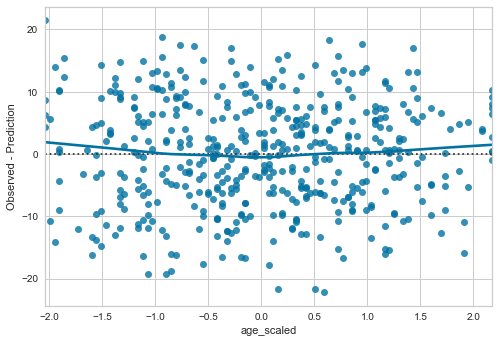

In [18]:
performance = pd.DataFrame()
performance["residuals"] = model.predict(x) - data.bounce_time
performance["age_scaled"] = data.age_scaled
performance["predicted"] = model.predict(x)

ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

The residuals are much better than before, being more evenly distributed with respect to age, and if we look at the predictions with each county:


Method       RMSE
0  Linear Regression  14.928334
1              Fixed   8.563396

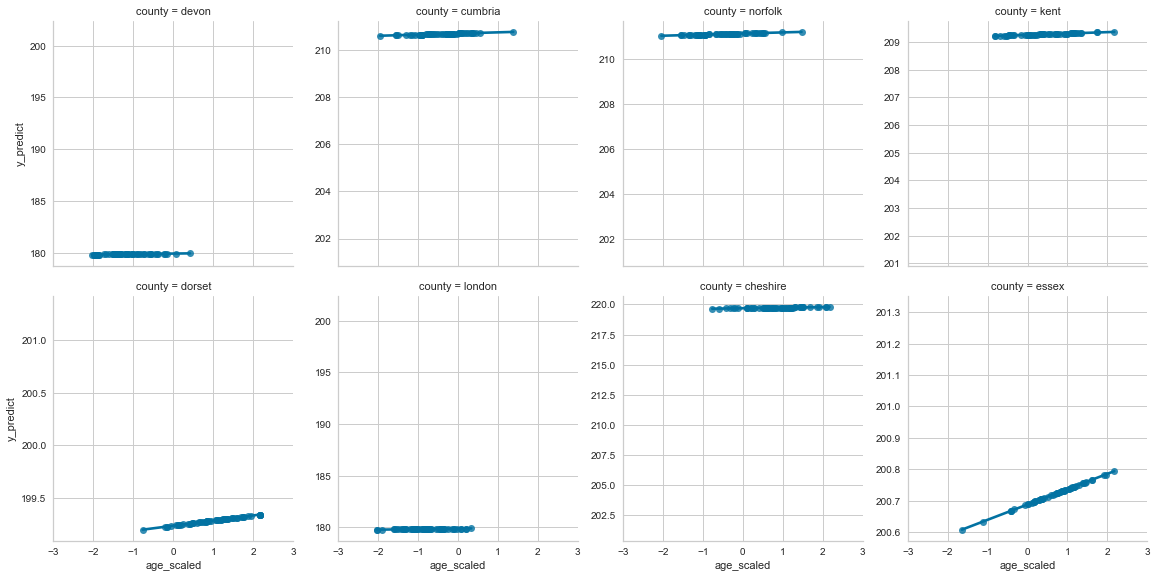

In [19]:
data_new["y_predict"] = model.predict(x)
grid = sns.lmplot(x = "age_scaled", y = "y_predict", col = "county", sharey=False, col_wrap = 4, data = data_new, height=4)
grid.set(xlim=(-3,3))

y_predict = model.predict(x)
RMSE = np.sqrt(((y-y_predict)**2).values.mean())
results.loc[1] = ["Fixed", RMSE]
results

Now we can se that the coefficient for the gradient given to age is substnantially smaller, and is likely no longer significant. Let's just check that by making a table of the coefficients:

In [20]:
# coefficient for age and the counties
pd.DataFrame.from_records(list(zip(np.concatenate((["age_scaled"],counties)), model.coef_)))

0          1
0  age_scaled   0.048782
1       devon -21.381957
2     cumbria   9.391460
3     norfolk   9.824419
4        kent   7.938668
5      dorset  -2.079637
6      london -21.437323
7    cheshire  18.372916
8       essex  -0.628546

But what model have we actually fitted here? Is it what we wanted to investigate initially? The model is estimating the difference in bounce times between the counties now as well, and we aren't actually interested in that. If you were then this is correct to do so, but the website company just wanted to know whether age affects the bounce times. And by including county in we are obscuring this. So to look at the impact of age on bounce times we need to control for the variation between the different counties (as well as between the locations). So to do that, we have to treat our counties as _random effects_, and build a _mixed effect model!_

## Mixed effects models

A mixed effects model is ideal here as it will allow us to both use all the data we have (higher sample size) and better acknowledge the correlations between data coming from the counties and locations. We will also estimate fewer parameters and avoid problems with multiple comparisons that we would encounter while using separate regressions.

So in this model we treat our $\texttt{age}$, which is what we are interested in, as a _fixed effect_, and $\texttt{county}$ and $\texttt{location}$ as a _random effect_.

But what does that mean? Well it's sort of a middle ground here between assuming our coefficient for the gradient and intercept are all the same (what we did in the first regression) and assuming they are all independent and different. If we look back at our equations, we now may assume that while $b_0$ and $b_1$ are different for each county, the coefficients all come from a common group distribution, such as a normal distribution:

$$
\left\{ \begin{align*}
time_c &= b_{c0} + b_{c1}.age  \\[.5em]
b_{c0} &\sim N(\mu_{b_0}, \sigma^2_{b_0}) \\
b_{c1} &\sim N(\mu_{b_1}, \sigma^2_{b_1})
\end{align*} \right.
$$

So we now assume the intercepts $b_0$ and gradients $b_1$  come from a normal distribution centered around their respective group mean $\mu$ with a certain standard deviation $\sigma^2$, the values of which we also estimate.

#### Remark: Fixed _vs_ random?

In brief, we view fixed effects as the variables that we are interested in. We wanted to know about age so we recorded data on that and wanted to see how it impacted the response variable. County was not we were interested in, but we recorded it as we were aware that our sampling methodology could lead to clustering in our data that could invalidate the linear model from before. If we hadn't recorded that someone who was given this dataset to analyse may have incorrectly said that  age was an important predictor of bounce rate.

Random effects are often our groups we are trying to control for, like county in our example. In particualr twe control for counties when we have not exhausted all the available groups - we only had 8 counties in England. If we wanted to make predicitons about the counties, then we would have tried to sample them better firstly, and also treat them as a fixed effect. 

We will now fit our model using the $\texttt{statsmodels}$ library. In this initial model we will look at how the bounce time relates to the scaled ages, while controlling for the impact of counties by allowing for a random intercept for each country, _i.e._ we are saying that each county has its own random intercept but that the slopes are still the same with respect to age.

In [21]:
#!pip install statsmodels -y
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [22]:
# construct our model, with our county now shown as a group
md = smf.mixedlm("bounce_time ~ age_scaled", data, groups=data["county"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: bounce_time
No. Observations: 480     Method:             REML       
No. Groups:       8       Scale:              74.7350    
Min. group size:  60      Log-Likelihood:     -1733.0397 
Max. group size:  60      Converged:          Yes        
Mean group size:  60.0                                   
---------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   201.316    5.175 38.902 0.000 191.174 211.459
age_scaled    0.136    0.612  0.221 0.825  -1.065   1.336
Group Var   212.999   13.382                             



In this summary of the model, we can clearly see that the $\texttt{age_scaled}$ is having a more noticable impact than in the fixed model earlier (coefficient of 0.136 rather than 0.048), however, importantly it is still not significantly different to 0, with the 95% interval for this coefficient spanning -1.065 - 1.336.

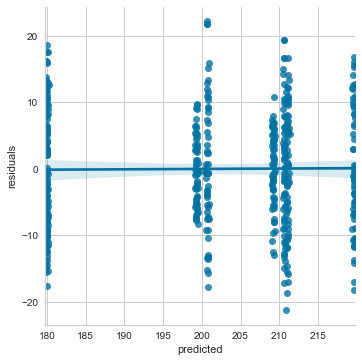

In [23]:
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["age_scaled"] = data.age_scaled
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)

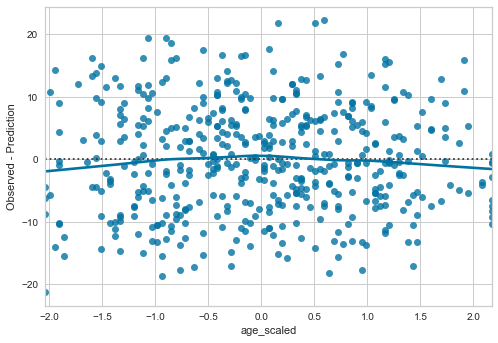

In [24]:
ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [25]:
y_predict = mdf.fittedvalues
RMSE = np.sqrt(((y-y_predict)**2).values.mean())
results.loc[2] = ["Mixed", RMSE]
results

Method       RMSE
0  Linear Regression  14.928334
1              Fixed   8.563396
2              Mixed   8.563948

In fact, the last two approaches achieve very similar results. The residuals plot looks alomst identical to the previous one where we were treating the county as a fixed effect. Why? 

Well, have a think about what we have actually just implemented. All we have done is say in the last one that the county has a randome intercept, but the same slope. This is very similar to the fixed effect approach, where county was included as a term that would impact the intercept. All we have changed is sayng that the intercepts for each county are probably drawn from a similar distribution. To ensure that each county has its own random slope we need to include this in our random effects forumla, like so:

In [26]:
# construct our model, but this time we will have a random interecept AND a random slope with respect to age
md = smf.mixedlm("bounce_time ~ age_scaled", data, groups=data["county"], re_formula="~age_scaled")
mdf = md.fit()
print(mdf.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    bounce_time
No. Observations:      480        Method:                REML       
No. Groups:            8          Scale:                 72.8722    
Min. group size:       60         Log-Likelihood:        -1733.3946 
Max. group size:       60         Converged:             No         
Mean group size:       60.0                                         
--------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              202.140    8.356 24.190 0.000 185.762 218.518
age_scaled               0.161    1.196  0.134 0.893  -2.184   2.505
Group Var              558.143                                      
Group x age_scaled Cov -51.614                                      
age_scaled Var           8.621                    

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2206: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2218: ConvergenceWarning: Gradient optimization failed, |grad| = 7.170191
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


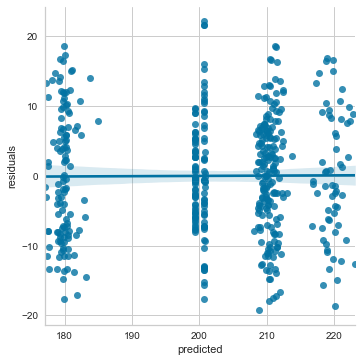

In [27]:
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["age_scaled"] = data.age_scaled
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)

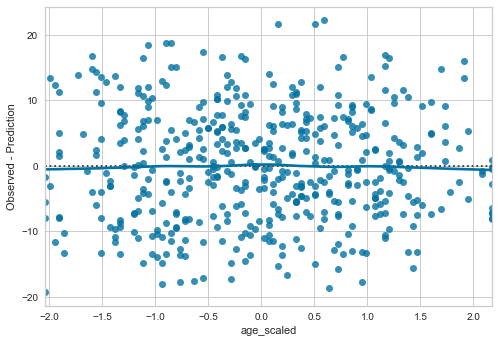

In [28]:
ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [29]:
y_predict = mdf.fittedvalues
RMSE = np.sqrt(((y-y_predict)**2).values.mean())
results.loc[3] = ["Mixed_Random_Slopes", RMSE]
results

Method       RMSE
0    Linear Regression  14.928334
1                Fixed   8.563396
2                Mixed   8.563948
3  Mixed_Random_Slopes   8.475248

So our mixed model with the random slopes is now performing much better, with our residuals much better ditributed. Crucially though, we can see that age does not impact the bounce rate, with the confidence intervals for the gradient with respect to age spanning -2.184 - 2.505 after we have controlled for the random variation caused by the county properly, _i.e._ with a random slope and intercept. 

What we have seen in our data was that individuals in certain counties took longer on the website, and that they happened to also be old. However, to get to this distinction we had to first treat county as a random effect. But what about location?

In [30]:
data["location_county"] = data["location"] + "_" + data["county"]
data.head()

md = smf.mixedlm("bounce_time ~ age_scaled", data, groups=data["location_county"], re_formula="~age_scaled")
mdf = md.fit()
print(mdf.summary())

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2202: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)


               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    bounce_time
No. Observations:      480        Method:                REML       
No. Groups:            24         Scale:                 23.7942    
Min. group size:       20         Log-Likelihood:        -1504.9078 
Max. group size:       20         Converged:             Yes        
Mean group size:       20.0                                         
--------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              201.491    3.448 58.441 0.000 194.734 208.249
age_scaled               0.151    0.393  0.385 0.700  -0.618   0.920
Group Var              282.769   21.275                             
Group x age_scaled Cov  -8.285    2.478                             
age_scaled Var           0.386    0.494           

In [31]:
y_predict = mdf.fittedvalues
RMSE = np.sqrt(((y-y_predict)**2).mean())
results.loc[4] = ["Nested_Mixed", RMSE]
results

Method       RMSE
0    Linear Regression  14.928334
1                Fixed   8.563396
2                Mixed   8.563948
3  Mixed_Random_Slopes   8.475248
4         Nested_Mixed   4.764192